In [2]:
import numpy as np
import numpy.matlib as ml
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [3]:
sns.set_theme(style="darkgrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

In [4]:
import os
import FUNC_Stable3_GasSphere_ElasticShellViscFlesh as vefunc

# Fixed Parameters
Most parameters are fixed for Cod

In [72]:
M_order=2

ro1=1027    # Surronding Water density  "kg/m³"
ro2=1040  # Surronding viscouis layer (fish flesh) density  "kg/m³"
ro3=1141  # Elastic sphere Density "kg/m³"
ro4=51.3  # Inner Gas Sphere Density "kg/m³"

c1=1479    # Surronding Water speed of sound "m/s" @ 4,3deg 31,2 PSU
c2=1523    # Surronding viscouis layer (fish flesh) speed of sound "m/s"
#c3=1480    # Elastic sphere speed of sound "m/s"
c4=325.1    # gas speed of sound "m/s"

Eta2=2*0.428572
Mu2=Eta2
Kisi2=Mu2+4*Eta2/3
    
Mu3=3*1.0E6  # "N/m²" shear rigidity of elastic shell
Landa3=2.4*1E9  # "N/m²" Compressional rigidity of elastic shell

c3=(ro3/(Landa3+2*Mu3))**-0.5    # Elastic sphere speed of sound "m/s"
    
Delta=0.01*1E-3 # Swimbladder wall thickness
R4=0.8*1E-3 #0.001  # (m) radius of gas sphere
R3=R4+Delta  # (m) radius of elastic shell 
R2=10*1E-3  # (m) radius till viscous layer
R2=R4*( (1+(ro1-ro4)/(ro2-ro1))**(1/3) ) # Eq 18 in our JASA mesopelagic paper

In [73]:
# set fixed values
params_cod ={'ro1':ro1,
            'ro2':ro2,
            'ro3':ro3,
            'ro4':ro4,
            'c1':c1,
            'c2':c2,
            'c3':c3,
            'c4':c4,
            'Eta2':Eta2,
            'Mu3':Mu3,
            'Landa3':Landa3,
            'Kisi2':Kisi2}

## Set up simulation

In [74]:
# Frequency range
min_freq=1*1000
max_freq=1000*1000
frequencySpacing=100
Freq_vec=np.arange(min_freq,max_freq,frequencySpacing) 

## Run ensembles

In [75]:
nsim = 1
nfreqs = len(Freq_vec)
ind_sim=0
# Allocate space for speed
TS_simulations = np.zeros((nsim*nfreqs))
freqs=Freq_vec

    
# Set new radius parameters
#R3 = 2 # From Khodabandeloo 2021
#R2 = 10 # From Khodabandeloo 2021
params_cod['R2'] = R2
params_cod['R3'] = R3
params_cod['R4'] = R4

# Run the v-e model
print('Running simulations for radius %.2f mm and total radius %.2f mm, simulation %.0f' %(R3,R2,0))
TS_vec_cod = vefunc.run_ve(Freq_vec, M_order, params_cod)

TS_simulations[ind_sim*nfreqs:ind_sim*nfreqs+nfreqs] = TS_vec_cod
freqs[ind_sim*nfreqs:ind_sim*nfreqs+nfreqs] = Freq_vec

Running simulations for radius 0.00 mm and total radius 0.00 mm, simulation 0


## Create dataframe for results

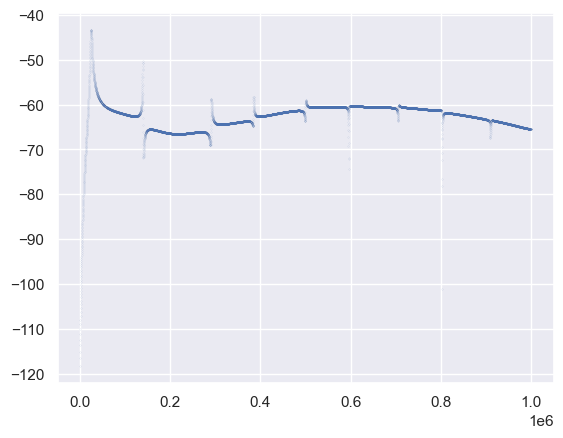

In [79]:
ve_simdata=pd.DataFrame({'freqs':freqs/1000,'TS_cod':TS_simulations, 'R3 (mm)': R3, 'R2 (mm)': R2})
F_TS_MAT=np.concatenate((freqs.reshape(-1,1),TS_simulations.reshape(-1,1)),axis=1)
plt.plot(F_TS_MAT[:,0],F_TS_MAT[:,1], '.', markersize=0.1)

In [80]:
ve_simdata


,freqs,TS_cod,R3 (mm),R2 (mm)
0,1.0,-118.227062,0.00081,0.003389
1,1.1,-116.568263,0.00081,0.003389
2,1.2,-115.053355,0.00081,0.003389
3,1.3,-113.659236,0.00081,0.003389
4,1.4,-112.367950,0.00081,0.003389
...,...,...,...,...
9985,999.5,-65.355025,0.00081,0.003389
9986,999.6,-65.353111,0.00081,0.003389
9987,999.7,-65.351079,0.00081,0.003389
9988,999.8,-65.348924,0.00081,0.003389


# Plot results


(1.0, 1000.0)

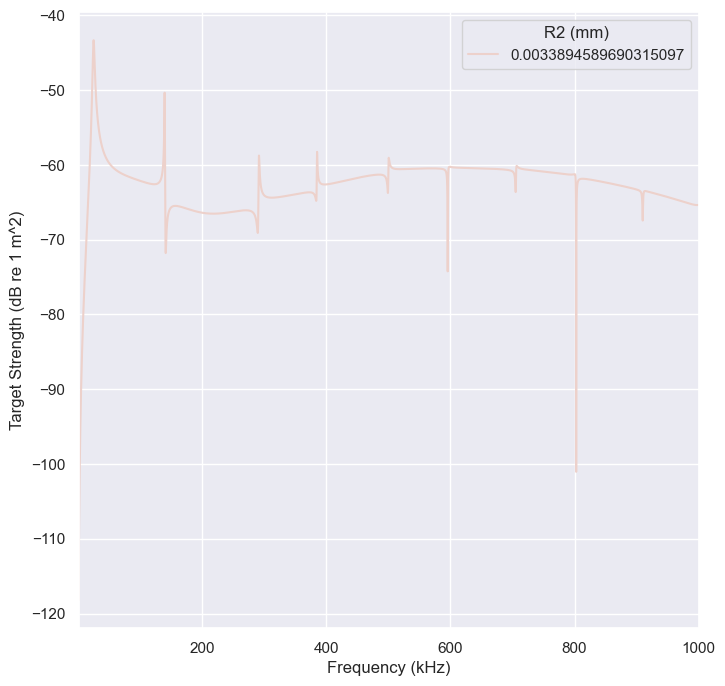

In [81]:
plt.figure(figsize=(8,8))
sns.lineplot(data=ve_simdata, x='freqs',y='TS_cod',hue='R2 (mm)')
plt.ylabel('Target Strength (dB re 1 m^2)')
plt.xlabel('Frequency (kHz)')
plt.xlim([1, 1000])

## Write to file
Write the results in a text file with a header of parameters and a row for each frequency and TS.

Should I add R3?

In [82]:
# uncomment when ready.
vefunc.write_ve('./ve_results/ve_cod_28092023.txt', M_order, params_cod, F_TS_MAT)

In [83]:
ve_simdata['sigbs'] = 10**(ve_simdata['TS_cod']/10)
mean_bs = ve_simdata.groupby(["freqs"]).agg({'sigbs':'mean'})

(283.0, 383.0)

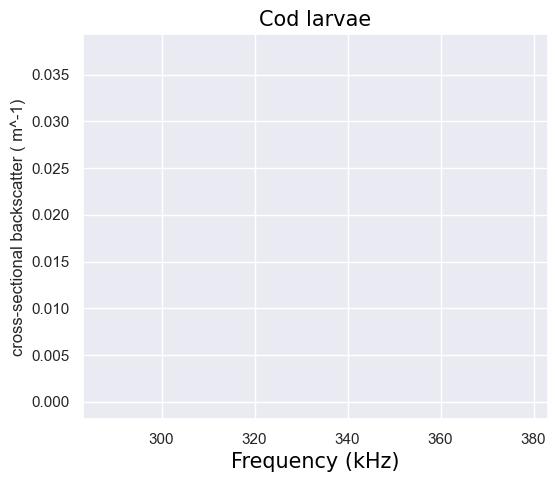

In [86]:
plt.figure(figsize=(6,5))
sns.lineplot(data=ve_simdata, x='freqs',y='sigbs')
plt.ylabel('cross-sectional backscatter ( m^-1)')
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Cod larvae', title_font)
plt.xlim([283, 383])

(283.0, 383.0)

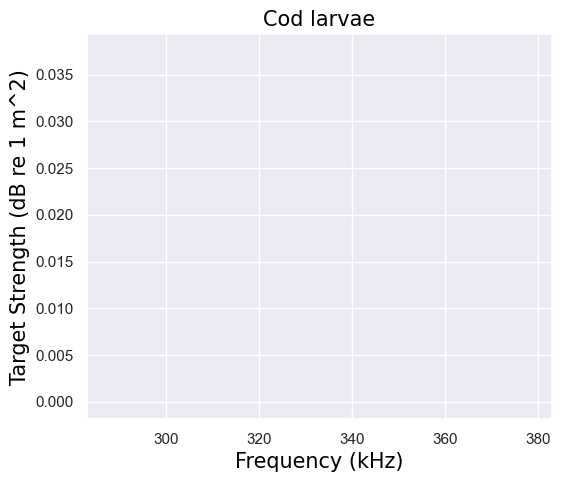

In [87]:
plt.figure(figsize=(6,5))
plt.plot(ve_simdata['freqs'].unique(),mean_bs)
plt.ylabel('Target Strength (dB re 1 m^2)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Cod larvae', title_font)
plt.xlim([283, 383])

In [88]:
simulations=ve_simdata
n_boots=100
percentiles=(2.5, 97.5)
# First, calculate mean for each frequency of the whole sample
mean_bs = simulations.groupby(['freqs']).mean()['sigbs']


# Resample , calculate mean repeat n_boot times, then calculate the SPREAD of the MEANS.
sigbs = simulations.sigbs
freq = simulations.freqs
freqs = np.unique(freq)

# Create our empty array to fill the results
ci_boot = np.zeros([2, len(freqs)])

# Resample over each frequency
for i in range(len(freqs)):
    sigbs_selectfreq = sigbs[freq==freqs[i]]

    # Create our empty array to fill the results              
    bootstrap_means = np.zeros([n_boots])

    # Resample within the values of the selected frequency and calculate the mean
    for ii in range(n_boots):
    # Generate random indices for our data *with* replacement, then take the sample mean
        random_sample = resample(sigbs_selectfreq)
        bootstrap_means[ii] = random_sample.mean(axis=0)

    # Save the percentiles of the bootstraped means for the selected frequency
    ci_boot[:,i] = np.percentile(bootstrap_means, percentiles, axis=0)

Text(0.5, 1.0, 'Cod larvae')

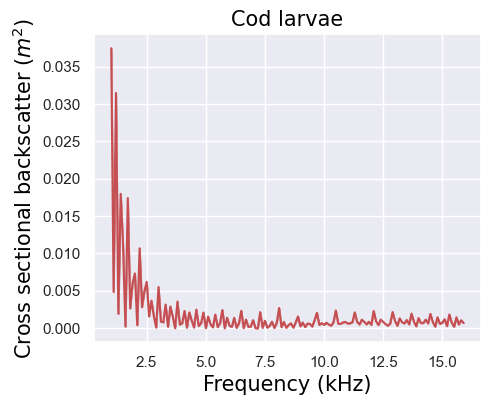

In [89]:
plt.figure(figsize=(5,4))
plt.plot(freqs, mean_bs, 'r')
plt.fill_between(freqs, ci_boot[0,:], ci_boot[1,:], alpha=0.5, color='r')
plt.ylabel('Cross sectional backscatter ($m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Cod larvae', title_font)

In [90]:
plt.plot(R2_simulations*2,R3_simulations*2, '.')


NameError: name 'R2_simulations' is not defined